In [196]:
import os
import cv2
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import cifar10
from keras.layers import (Activation, Conv3D, Dense, Dropout, Flatten,
                          MaxPooling3D, TimeDistributed, LSTM, Reshape, BatchNormalization,LeakyReLU)

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam,Adadelta
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import videoto3d
from tqdm import tqdm


def plot_history(history, result_dir):
    plt.plot(history.history['acc'], marker='.')
    plt.plot(history.history['val_acc'], marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['acc', 'val_acc'], loc='lower right')
    plt.savefig(os.path.join(result_dir, 'model_accuracy.png'))
    plt.close()

    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(os.path.join(result_dir, 'model_loss.png'))
    plt.close()



def save_history(history, result_dir):
    loss = history.history['loss']
    acc = history.history['acc']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_acc']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))

def str_2_label(str_ch):
    if '逆旋' in str_ch:
        return 'Counterclockwise'
    elif'正旋' in str_ch:
        return 'Clockwise'
    elif '上下' in str_ch:
        return 'UpDown'
    elif 'Thumbup' in str_ch:
        return 'ThumpUp'
    elif 'Stop' in str_ch:
        return 'Stop'
    return None

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.6/site-packages/t

# Config

In [197]:
img_pixel = 32
epoch=300
nclass=6
output='./out'
color=True
skip=False
depth=15
batch=800

channel = 3

# load

In [253]:
loadeddata = np.load('./dataset_6_50_False_jester_train_rgb.npz')
nb_classes = nclass
X, Y = loadeddata["X"], loadeddata["Y"]
loadedtestdata = np.load('./dataset_6_50_False_jester_validation_rgb.npz')
valX, valY = loadedtestdata["X"], loadedtestdata["Y"]

In [255]:
# X = np.concatenate((X, valX), axis=0)
Y = np.concatenate((Y, valY), axis=0)
print(Y.shape)

(9300,)


In [256]:
X.shape

(9000,)

In [257]:
print(Y[0])
print(Y[2000])
print(Y[4000])
print(Y[5000])
print(Y[6000])
print(Y[8000])
# print(Y[0])
# print(Y[500])
# print(Y[1000])
# print(Y[1500])
# print(Y[2000])
# print(Y[2500])

No gesture
Turning Hand Counterclockwise
Swiping Left
Stop Sign
Turning Hand Clockwise
Swiping Right


In [258]:
Y = pd.DataFrame.as_matrix(pd.get_dummies(Y))
# print(Y[0])
# print(Y[3000])
# print(Y[6000])
# print(Y[9000])
# print(Y[11500])

print(Y[0])
print(Y[2000])
print(Y[4000])
print(Y[5000])
print(Y[6000])
print(Y[8000])

[1 0 0 0 0 0]
[0 0 0 0 0 1]
[0 0 1 0 0 0]
[0 1 0 0 0 0]
[0 0 0 0 1 0]
[0 0 0 1 0 0]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [260]:
valY = Y[-valY.shape[0]:]
Y = Y[0: (len(Y) - valY.shape[0])]
print(Y.shape)
print(valY.shape)
# valX = X[-valX.shape[0]:]
# X = X[0: (len(X) - valX.shape[0])]

(9000, 6)
(300, 6)


In [261]:
valX[0].shape

(37, 32, 32, 3)

In [262]:
valXX = np.zeros((len(valX), depth,img_pixel,img_pixel,3))
for index, item in enumerate(valX):
    frame_len = len(valX[index])
#     print(frame_len)
    if frame_len <= depth:
        print(index)
        for i in range(depth):
            frame = valX[index][i%frame_len]
            valXX[index,i,:,:] = frame
    else:
        mid_frame = int(frame_len/2)
        startframe = mid_frame-7
        for i in range(depth):
            valXX[index,i,:,:] = valX[index][startframe+i]
valX = valXX.astype(int)
del valXX

In [263]:
# plt.imshow(valXX.astype(int)[0,12])

In [264]:
# XX = np.zeros((len(X), depth,img_pixel,img_pixel,3))
YY = []
XX =[]
count = 0
for index, item in enumerate(X):
    if len(X[index]) == 0:
        print('empty'+str(index))
        continue
#---------------------mid
    temp = np.zeros((depth,img_pixel,img_pixel,3))
    frame_len = len(X[index])
    if frame_len <= depth:
        for i in range(depth):
            temp[i] = X[index][i%frame_len]
        XX.append(temp)
        YY.append(Y[index])
        count = count +1
    else:
        mid_frame = int(frame_len/2)
        startframe = mid_frame-8
        for i in range(depth):
#             print(i)
#             print(startframe)
            temp[i] = X[index][startframe+i]
        XX.append(temp)
        YY.append(Y[index])
        count = count +1

In [265]:
print(len(YY))
Y = np.zeros((len(YY), 6))
for i in range(len(YY)):
    Y[i] = YY[i]
del YY
print(Y.shape)

9000
(9000, 6)


In [266]:
XXX = np.zeros((len(XX), depth,img_pixel,img_pixel,3))

In [267]:
for i in range(len(XX)):
    XXX[i] = XX[i]
print(XXX.shape)
X=XXX.astype(int)
print(X.shape)
del XX
del XXX

(9000, 15, 32, 32, 3)
(9000, 15, 32, 32, 3)


# model

In [273]:

print('X_shape:{}\nY_shape:{}'.format(X.shape, Y.shape))

#     Define model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(X.shape[1:]), padding="same"))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(Conv3D(32, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(Conv3D(64, padding="same", kernel_size=(3, 3, 3)))
model.add(Activation('relu'))
# model.add(LeakyReLU())
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding="same"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(101, activation='softmax'))
model.load_weights('/home/jovyan/20_GeoThings_Road/3D-CNN/3DCNN-master/3dcnn_batchnorm_result/ucf101_3dcnnmodel.hd5', by_name=True)
# model.load_weights('/home/jovyan/20_GeoThings_Road/3D-CNN/3DCNN-master/3dcnn_leakyrelu_result/ucf101_3dcnnmodel.hd5', by_name=True)
#     print(model.summary())

model.pop()
# model.add(Reshape([None,16,16]))
# model.add(LSTM(256,dropout=0.2))
model.add(Dense(nb_classes, activation='softmax'))
# model.compile(loss=categorical_crossentropy,
#               optimizer=Adam(), metrics=['accuracy'])
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(), metrics=['accuracy'])
print(model.summary())

X_shape:(9000, 15, 32, 32, 3)
Y_shape:(9000, 6)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_50 (Conv3D)           (None, 15, 32, 32, 32)    2624      
_________________________________________________________________
activation_49 (Activation)   (None, 15, 32, 32, 32)    0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 15, 32, 32, 32)    27680     
_________________________________________________________________
activation_50 (Activation)   (None, 15, 32, 32, 32)    0         
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 5, 11, 11, 32)     0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 11, 11, 32)     0         
_________________________________________________________________
conv3d_52 (Conv3D)          

In [274]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0000000001)
saveModel = ModelCheckpoint('./out_model/weights.{epoch:02d}-{val_acc:.2f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)

plot_model(model, show_shapes=True,
           to_file=os.path.join(output, 'model.png'))

# X_train, X_test, Y_train, Y_test = train_test_split(
#     X, Y, test_size=0.2, random_state=42, shuffle=True)

In [218]:
history = model.fit(X, Y, validation_data=(valX, valY), batch_size=batch,epochs=epoch, verbose=1, shuffle=True, callbacks=[reduce_lr, saveModel])
model.evaluate(X_test, Y_test, verbose=1)
model_json = model.to_json()
if not os.path.isdir(output):
    os.makedirs(output)
with open(os.path.join(output, 'ucf101_3dcnnmodel.json'), 'w') as json_file:
    json_file.write(model_json)
# model.save_weights(os.path.join(args.output, 'ucf101_3dcnnmodel.hd5'))

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

    
#     print(model.predict(X_test))
#     print(Y_test)
    
plot_history(history, output)
save_history(history, output)

Train on 9000 samples, validate on 300 samples
Epoch 1/300
9000/9000 [==============================] - 12s 1ms/step - loss: 2.6748 - acc: 0.1693 - val_loss: 2.0048 - val_acc: 0.1900
Epoch 2/300
9000/9000 [==============================] - 9s 1ms/step - loss: 2.1132 - acc: 0.2780 - val_loss: 1.9369 - val_acc: 0.2533
Epoch 3/300
9000/9000 [==============================] - 9s 1ms/step - loss: 1.7714 - acc: 0.3602 - val_loss: 2.0767 - val_acc: 0.4467
Epoch 4/300
9000/9000 [==============================] - 10s 1ms/step - loss: 1.5600 - acc: 0.4109 - val_loss: 1.4878 - val_acc: 0.3267
Epoch 5/300
9000/9000 [==============================] - 10s 1ms/step - loss: 1.4072 - acc: 0.4514 - val_loss: 1.6121 - val_acc: 0.2533
Epoch 6/300
9000/9000 [==============================] - 10s 1ms/step - loss: 1.2767 - acc: 0.4820 - val_loss: 1.5349 - val_acc: 0.3767
Epoch 7/300
9000/9000 [==============================] - 10s 1ms/step - loss: 1.1948 - acc: 0.5080 - val_loss: 1.2880 - val_acc: 0.4333
Epo

KeyboardInterrupt: 

# VAl

In [276]:
model.load_weights('/home/jovyan/20_GeoThings_Road/3D-CNN/3DCNN-master/out_model/history/weights.46-0.74.hdf5')

In [277]:
print(np.argmax(model.predict(valX),axis=1))
# print(model.predict(X_test))
print(np.argmax(valY, axis=1))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 5 4 5 5 5 3 4 4 4 5 5 5 5 5 5 5 5 4 4 5 5 5 4 1
 5 5 4 4 5 5 1 4 5 4 5 5 5 4 4 4 1 5 5 5 1 4 5 5 4 5 2 2 0 2 2 5 2 2 2 3 2
 2 3 2 3 2 2 3 2 2 2 3 2 2 2 3 2 2 3 2 3 3 2 2 1 2 2 2 2 2 2 2 3 2 2 2 2 3
 2 2 2 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 0 1 1 1 1 1 4 1 5 1 1 1 0 4 1 1 4
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 2 4 4 4 5 5 4 4 4 5 4 4 4 4 4 5 4 4
 4 5 2 4 5 5 4 5 4 4 1 5 4 5 5 4 5 4 5 5 4 4 4 4 5 5 4 5 3 4 3 4 3 3 2 3 3
 3 4 3 2 3 2 3 3 3 4 2 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 2 3 3 3 3 3 3
 3 3 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 

In [278]:
df = pd.DataFrame({'pre':np.argmax(model.predict(valX),axis=1), 'true':np.argmax(valY, axis=1)})

In [279]:
df=df.replace([0, 1, 2, 3,4,5], ['No gesture','Stop Sign', 'Swiping Left', 'Swiping Right', 'Turning Hand Clockwise', 'Turning Hand CounterClockwise'])

In [280]:
# df.to_csv('./out.csv')

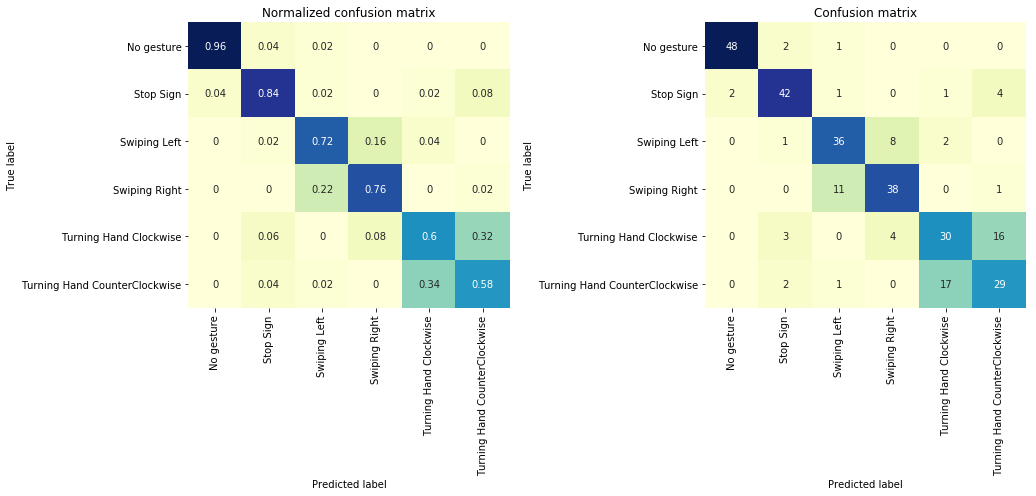

In [281]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline  

# Put the results in
y_true = df['true']
y_pred = df['pre']


labels = sorted(list(set(y_true)))
cmx_d = confusion_matrix(y_pred, y_true, labels=labels)
cmxn_d = cmx_d.astype('float') / cmx_d.sum(axis=0)[np.newaxis ,:]
cmx_df = pd.DataFrame(cmx_d, index=labels, columns=labels)
cmxn_df = pd.DataFrame(cmxn_d, index=labels, columns=labels)

plt.figure(figsize = (14.5, 7))
plt.subplot(121)
sns.heatmap(cmxn_df, annot=True, cmap='YlGnBu', cbar=False)
plt.title('Normalized confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.subplot(122)
sns.heatmap(cmx_df, annot=True, cmap='YlGnBu', cbar=False)
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
